importing the modules required for neural network

In [23]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# libraries for pipleline optimization
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Categorical
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
# references: https://knowledge.dataiku.com/latest/data-preparation/pipelines/concept-pipeline-optimization.html
#https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

libraries added to implement bayesian optimization

In [24]:
# import warnings
# from bayes_opt.constraint import ConstraintModel
# from bayes_opt import BayesianOptimization, UtilityFunction, util
# # from .target_space import TargetSpace
# # from .event import Events, DEFAULT_EVENTS
# # from .logger import _get_default_logger
# # from .util import UtilityFunction, acq_max, ensure_rng
# from sklearn.gaussian_process.kernels import Matern
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.metrics import roc_auc_score

importing the dataset

In [25]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 0:30    23.90   21.65    22.40     87.50      19.67    1   
1         1/1/2006 1:00    23.90   21.70    22.40     88.00      18.56    1   
2         1/1/2006 1:30    23.80   21.65    22.35     88.00      19.09    1   
3         1/1/2006 2:00    23.70   21.60    22.30     88.00      17.40    1   
4         1/1/2006 2:30    23.70   21.60    22.30     88.00      17.00    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87643  31/12/2010 22:00    22.60   19.10    20.40     81.00      23.86   31   
87644  31/12/2010 22:30    22.45   19.05    20.30     81.50      26.49   31   
87645  31/12/2010 23:00    22.30   19.00    20.20     82.00      25.18   31   
87646  31/12/2010 23:30    22.05   19.05    20.15     83.50      26.19   31   
87647     1/1/2011 0:00    21.80   19.10    20.10     85.00      24.62    1   

       Month  Year  Minutes  SYSLoad  
0          1

In [26]:
# prints the high level information about the data
df.info()
# gives additional statistical information
'''df.describe()'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       87648 non-null  object 
 1   DryBulb    87648 non-null  float64
 2   DewPnt     87648 non-null  float64
 3   WetBulb    87648 non-null  float64
 4   Humidity   87648 non-null  float64
 5   ElecPrice  87648 non-null  float64
 6   Day        87648 non-null  int64  
 7   Month      87648 non-null  int64  
 8   Year       87648 non-null  int64  
 9   Minutes    87648 non-null  int64  
 10  SYSLoad    87648 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.4+ MB


'df.describe()'

In [27]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

In [28]:
# df1.corr()
# # to see the correlation between features
# # this helps to see how one parameters has effects on others
# # lets see the plot of correlation data
# sns.heatmap(df1.corr(), annot= True)
# plt.rcParams["figure.figsize"]=(15,10)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

In [29]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
X = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder this is for classification tasks
'''ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this'''

"ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')\nx = ct.fit_transform(x)\nx = x.toarray() # converts encoded data to dense array (optional) would show error without this"

Splitting the dataset into the training and test set

In [30]:
# we will split the data into training and testing data using following code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean deviation of train data: {x_train.mean()}')

feature standardization and conversion to tensor

In [31]:
# Feature Scaling (not necessary for neural networks, but can be applied)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean of train data: {x_train.mean()}')
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
len(X_train)
#len(test_loader)

70118

Pipeline Preprocessing is done using following code

In [32]:
X = pd.DataFrame(X)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [33]:
# Define the pipeline for Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the parameter space for Random Forest
rf_param_space = {
    'regressor__n_estimators': Integer(10, 1000),
    'regressor__max_depth': Integer(3, 40),
    'regressor__min_samples_split': Integer(2, 10),
    'regressor__min_samples_leaf': Integer(1, 5)
}

# Define the pipeline for Neural Network
nn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor())
])

# Define the parameter space for Neural Network
nn_param_space = {
    'regressor__hidden_layer_sizes': Integer(8, 256, prior='log-uniform'),
    # 'regressor__hidden_layer_sizes':[(x, y, z) for x in range(10, 101, 10) 
    #                                   for y in range(10, 101, 10) 
    #                                   for z in range(10, 101, 10)],
    'regressor__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'regressor__alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'regressor__max_iter': Integer(10, 100),
    'regressor__learning_rate_init': Real(0.0001, 0.1, prior='log-uniform')
}

# Perform hyperparameter optimization for Random Forest
rf_optimizer = BayesSearchCV(
    rf_pipeline, 
    rf_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
rf_optimizer.fit(X_train, y_train)

# Perform hyperparameter optimization for Neural Network
nn_optimizer = BayesSearchCV(
    nn_pipeline, 
    nn_param_space, 
    n_iter=20, 
    cv=5, 
    n_jobs=-1
)
nn_optimizer.fit(X_train, y_train)

# Evaluate the best models
rf_best_score = rf_optimizer.best_score_
nn_best_score = nn_optimizer.best_score_

print(f"Best Random Forest score: {rf_best_score}")
print(f"Best Neural Network score: {nn_best_score}")


Best Random Forest score: 0.9277029488780235
Best Neural Network score: 0.8264393987808966


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Model for prediction

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in NN algorithm:
Mean Squared Error: 309325.9310232588
Mean Absolute Error: 443.2211899259168
r2_score: 0.8462242932394487
Best Parameters for the NN are:
OrderedDict({'regressor__activation': 'relu', 'regressor__alpha': 2.114217751084668e-05, 'regressor__hidden_layer_sizes': 136, 'regressor__learning_rate_init': 0.0975991602024436, 'regressor__max_iter': 69})


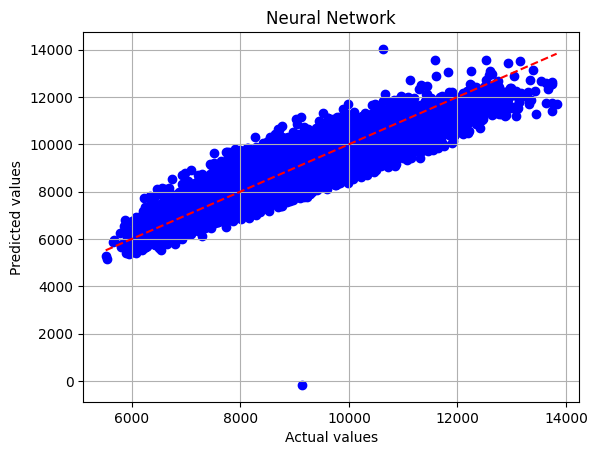

In [34]:
# Get the best model from hyperparameter optimization
best_nn_model = nn_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_nn_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

print('Best Parameters for the NN are:')
print(nn_optimizer.best_params_)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()

using random forest method for prediction and performance evaluation

Predicted values:
(17530,)
The Model performance parameter after HPO using Random Search Optimization in RF algorithm:
Mean Squared Error: 130663.82192111407
Mean Absolute Error: 259.66625028426466
r2_score: 0.935042880183093
Best Parameters for the RF are:
OrderedDict({'regressor__max_depth': 40, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 1000})


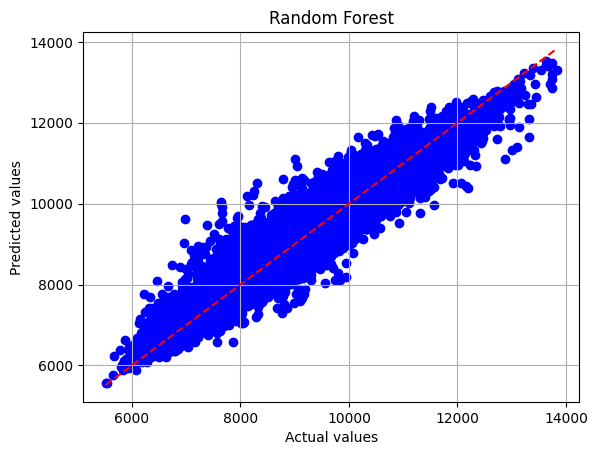

In [35]:
# Get the best model from hyperparameter optimization
best_rf_model = rf_optimizer.best_estimator_

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Print the predicted values
print("Predicted values:")
print(y_pred.shape)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in RF algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

print('Best Parameters for the RF are:')
print(rf_optimizer.best_params_)

# Plotting the results (optional)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit')
plt.scatter(y_test, y_pred, color='blue')
plt.title('Random Forest')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.grid(True)
plt.show()